In [88]:
import torch
import torch.nn
import torchvision
import matplotlib.pyplot as plt
from torchvision.datasets import CelebA
from torchvision import transforms
from torch.utils.data import DataLoader

In [89]:
#print("GUP name:", torch.cuda.get_device_name(), '\n')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Deice is:', device, '\n')
#print('Total number of GPUs:', torch.cuda.device_count())

Deice is: cuda 



In [90]:
from diffusers import DDPMScheduler
from PIL import Image
import numpy as np

# Hyperparameter: number of steps to turn clear image to noise
max_timesteps = 20

# Initialize DDPM Scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=max_timesteps,
                                beta_start=0.0001,
                                beta_end=0.02)

def plot_images(timesteps, noisy_images):
  fig, axes = plt.subplots(1, len(timesteps), figsize=(15, 15))
  for i, t in enumerate(timesteps):
    img = noisy_images[i].permute(1, 2, 0).numpy()  # Convert to HWC format
    img = np.clip(img, 0, 1)  # Ensure the values are in [0, 1]
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f't = {t}')
    axes[i].axis('off')
  plt.savefig('imgx.png')
  plt.show()

def get_img_subregion(img, x, y, w, h):
  return img[:, y:y+h, x:x+w]

def get_corruption_region(img, w=20, h=20):
  _, H, W = img.shape
  x = torch.randint(0, W - w + 1, (1,))
  y = torch.randint(0, H - h + 1, (1,))
  return x, y, w, h

In [91]:
root = "/content/drive/MyDrive/CSCI 5527 - Final Project/Code/coco_subset_export/data"
annFile = "/content/drive/MyDrive/CSCI 5527 - Final Project/Code/coco_subset_export/labels.json"

dataset = torchvision.datasets.CocoDetection(root=root, annFile=annFile)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [92]:
import torchvision
from PIL import Image
import torchvision.transforms as T
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True).to(device)

def get_pred(img):
  model.eval()

  with torch.no_grad():
    prediction = model([torch.Tensor(img).to(device)])

  pred = prediction[0]

  #labels = pred['labels'].tolist()
  #label_names = [COCO_INSTANCE_CATEGORY_NAMES[i] if i < len(COCO_INSTANCE_CATEGORY_NAMES) else COCO_INSTANCE_CATEGORY_NAMES[0] for i in labels]

  #print(pred["boxes"][0])
  #print(COCO_INSTANCE_CATEGORY_NAMES[pred["labels"][0]])

  return pred["boxes"], label_names

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [93]:
import cv2

def downsample_img(image, bbox, size=(256, 256)):
  C, H, W = image.shape
  target_H, target_W = size

  image_hwc = np.transpose(image, (1, 2, 0))
  resized_image = cv2.resize(image_hwc, size, interpolation=cv2.INTER_LINEAR)
  resized_image = np.transpose(resized_image, (2, 0, 1))

  scale_x = target_W / W
  scale_y = target_H / H
  x, y, w, h = bbox
  scaled_bbox = (
      int(x * scale_x),
      int(y * scale_y),
      int(w * scale_x),
      int(h * scale_y)
  )

  return resized_image, scaled_bbox


In [94]:
from PIL import Image
from tqdm import tqdm

dataset_orig_imgs = []
dataset_masked_imgs = []
subregions = []

for i, datapoint in enumerate(iter(dataset)):
  #if (i > 50):
  #  break
  image = torch.Tensor(np.transpose(np.array(datapoint[0]), (2, 0, 1)))
  img_shape = image.shape

  mask_idx = 0

  bboxes = datapoint[1][mask_idx]["bbox"]
  x1, y1, w, h = bboxes

  label_name = datapoint[1][mask_idx]["supercategory"]
  label_name = datapoint[1][mask_idx]
  #print("label idx:", label_name)
  #new_dataset_labels.append(COCO_INSTANCE_CATEGORY_NAMES[label_name])

  #print("label:", COCO_INSTANCE_CATEGORY_NAMES[label_name])

  x = int(x1); y = int(y1); w = int(w); h = int(h);

  sub_img = torch.Tensor(get_img_subregion(image, x, y, w, h))
  sub_img_shape = sub_img.shape

  jumps = 8
  timesteps = torch.arange(0, max_timesteps, jumps)
  noise = torch.randn(sub_img_shape) * 255
  noisy_images = [torch.clone(torch.Tensor(image))]

  for j, t in tqdm(enumerate(timesteps)):
    noisy_image = noise_scheduler.add_noise(sub_img, noise, t)
    img_curr = torch.clone(image)
    img_curr[:, y:y+h, x:x+w] = noisy_image
    noisy_images.append((img_curr/255))

  scaled_img, scaled_bbox = downsample_img(image.numpy(), (x, y, w ,h), size=(224, 224))
  scaled_masked_img, _ = downsample_img(noisy_images[-1].numpy(), (x, y, w ,h), size=(224, 224))

  #print(scaled_img.shape)
  #print(scaled_masked_img.shape)

  dataset_orig_imgs.append(torch.Tensor(scaled_img))
  dataset_masked_imgs.append(torch.Tensor(scaled_masked_img))
  subregions.append(torch.Tensor(scaled_bbox))

# plot_images(timesteps, noisy_images)
#
# fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# axs[0].imshow(np.transpose(image, (1, 2, 0)))
# axs[0].axis('off')
# axs[0].set_title("Original Image")
#
# axs[1].imshow(np.transpose(new_dataset_images[0], (1, 2, 0)))
# axs[1].axis('off')
# axs[1].set_title("Noised Image")

# plt.tight_layout()
# plt.show()

orig_imgs = torch.stack(dataset_orig_imgs)
masked_imgs = torch.stack(dataset_masked_imgs)
subregions = torch.stack(subregions)


3it [00:00, 696.46it/s]
3it [00:00, 755.78it/s]
3it [00:00, 975.34it/s]
3it [00:00, 817.07it/s]
3it [00:00, 1173.45it/s]
3it [00:00, 901.55it/s]
3it [00:00, 1071.62it/s]
3it [00:00, 544.48it/s]
3it [00:00, 1226.29it/s]
3it [00:00, 1129.32it/s]
3it [00:00, 1020.10it/s]
3it [00:00, 890.07it/s]
3it [00:00, 1022.83it/s]
3it [00:00, 1327.31it/s]
3it [00:00, 1162.82it/s]
3it [00:00, 1189.20it/s]
3it [00:00, 1220.93it/s]
3it [00:00, 1362.97it/s]
3it [00:00, 1251.66it/s]
3it [00:00, 1273.06it/s]
3it [00:00, 1269.08it/s]
3it [00:00, 1375.03it/s]
3it [00:00, 639.44it/s]
3it [00:00, 1460.58it/s]
3it [00:00, 1200.54it/s]
3it [00:00, 1387.31it/s]
3it [00:00, 1152.28it/s]
3it [00:00, 1219.63it/s]
3it [00:00, 1263.98it/s]
3it [00:00, 1083.99it/s]
3it [00:00, 1219.63it/s]
3it [00:00, 1306.09it/s]
3it [00:00, 893.99it/s]
3it [00:00, 1195.75it/s]
3it [00:00, 1287.12it/s]
3it [00:00, 978.15it/s]
3it [00:00, 909.17it/s]
3it [00:00, 1128.71it/s]
3it [00:00, 1089.43it/s]
3it [00:00, 1175.97it/s]
3it [00:00,

In [95]:
print(orig_imgs.size())
print(masked_imgs.size())
print(subregions.size())

torch.Size([500, 3, 224, 224])
torch.Size([500, 3, 224, 224])
torch.Size([500, 4])


In [96]:
!pip install diffusers transformers accelerate

torch.Size([1, 3, 256, 256])
38 60 103 33
mask sum: tensor(196608., device='cuda:0') 196608


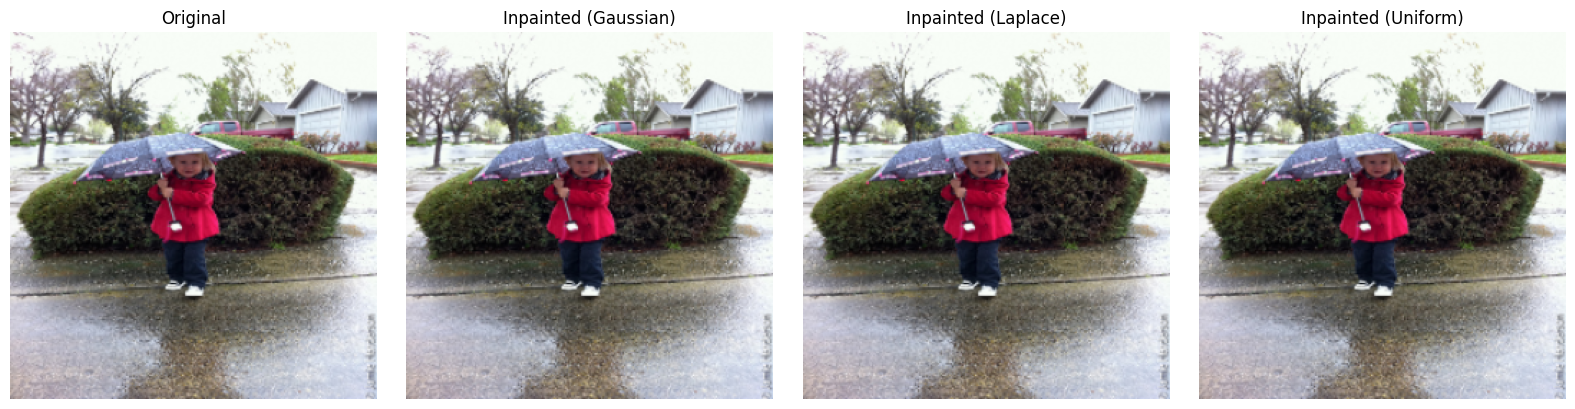

In [97]:
# === Load pretrained unconditional DDPM ===
model = UNet2DModel.from_pretrained("google/ddpm-cat-256").cuda()
model.eval()

scheduler = DDPMScheduler(num_train_timesteps=1000)
scheduler.set_timesteps(50)

def preprocess(image):
    tf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.Normalize([0.5], [0.5])
    ])
    return tf(image).unsqueeze(0).cuda()

def center_mask(shape, size=100):
    _, _, h, w = shape
    mask = torch.ones((1, 1, h, w), device='cuda')
    x, y = (w - size) // 2, (h - size) // 2
    mask[:, :, y:y+size, x:x+size] = 0
    return mask

def sample_custom_prior(shape, kind="gaussian"):
    if kind == "gaussian":
        return torch.randn(shape, device='cuda')
    elif kind == "laplace":
        dist = torch.distributions.Laplace(0, 1)
        return dist.sample(shape).to('cuda')
    elif kind == "uniform":
        return torch.rand(shape, device='cuda') * 2 - 1
    else:
        raise ValueError("Unknown prior")

@torch.no_grad()
def inpaint(model, scheduler, image, mask, prior="gaussian"):
    corrupted = mask * image + (1 - mask) * torch.randn_like(image) * 0.5
    x = sample_custom_prior(image.shape, kind=prior)

    for t in scheduler.timesteps:
        noise_pred = model(x, t).sample
        x = scheduler.step(noise_pred, t, x).prev_sample
        x = mask * corrupted + (1 - mask) * x

    return x

#original = preprocess(masked_imgs[2])
original = preprocess(orig_imgs[2] / 255)
mask = torch.ones_like(original)
segment = subregions[2]
x, y, w, h = subregions[2]
x = int(x); y = int(y); w = int(w); h = int(h);

print(original.shape)

print(x, y, w, h)
#mask[:, :, y:y+h, x:x+w] = 0.0

print("mask sum:", torch.sum(mask), mask.numel())


results = {
    "Gaussian": inpaint(model, scheduler, original, mask, prior="gaussian"),
    "Laplace": inpaint(model, scheduler, original, mask, prior="laplace"),
    "Uniform": inpaint(model, scheduler, original, mask, prior="uniform"),
}

def show(tensor, title):
    img = tensor.squeeze().detach().cpu()
    img = (img * 0.5 + 0.5).clamp(0, 1).permute(1, 2, 0).numpy()
    plt.imshow(img); plt.title(title); plt.axis("off")

plt.figure(figsize=(16, 4))

# Show original image first
plt.subplot(1, 4, 1)
show(original, "Original")

# Then the inpainted results
for i, (k, v) in enumerate(results.items()):
    plt.subplot(1, 4, i + 2)
    show(v, f"Inpainted ({k})")

plt.tight_layout()
plt.show()

In [99]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from diffusers import UNet2DModel, DDPMScheduler
from torchvision import transforms
import matplotlib.pyplot as plt

class InpaintingDataset(Dataset):
    def __init__(self, original_images, masked_images, subregions):
        self.original = original_images
        self.masked = masked_images
        self.bboxes = subregions

    def __len__(self):
        return len(self.original)

    def __getitem__(self, idx):
        return {
            'original': self.original[idx],
            'masked': self.masked[idx],
            'bbox': self.bboxes[idx]
        }

model = UNet2DModel(
    sample_size=224,
    in_channels=4,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(128, 128, 256, 256),
    down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D", "DownBlock2D"),
    up_block_types=("UpBlock2D", "AttnUpBlock2D", "UpBlock2D", "UpBlock2D")
)
model.cuda()

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

def train(model, dataloader, epochs=5, prior="gaussian"):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    model.train()

    for epoch in range(epochs):
        for batch in dataloader:
            orig = batch['original'].cuda()
            masked = batch['masked'].cuda()

            bsz = orig.shape[0]
            t = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=orig.device).long()

            if prior == "gaussian":
                noise = torch.randn_like(orig)
            elif prior == "laplace":
                noise = torch.distributions.Laplace(0, 1).sample(orig.shape).to(orig.device)
            elif prior == "uniform":
                noise = torch.rand_like(orig) * 2 - 1
            else:
                raise Exception("invalid dist")

            noisy_image = noise_scheduler.add_noise(orig, noise, t)
            mask = (masked != 0).float().mean(1, keepdim=True)
            model_input = torch.cat([masked, mask], dim=1)
            noise_pred = model(model_input, t).sample

            loss = ((noise_pred - noise) ** 2 * (1 - mask)).mean()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print(f"Epoch {epoch+1}/{epochs} - Loss: {loss.item():.4f}")

dataset = InpaintingDataset(orig_imgs, masked_imgs, subregions)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

train(model, dataloader, epochs=5, prior="laplace")

#model.save_pretrained("ddpm-inpaint-laplace")


Epoch 1/5 - Loss: 0.0225
Epoch 2/5 - Loss: 0.0014
Epoch 3/5 - Loss: 0.0069
Epoch 4/5 - Loss: 0.0003
Epoch 5/5 - Loss: 0.0000


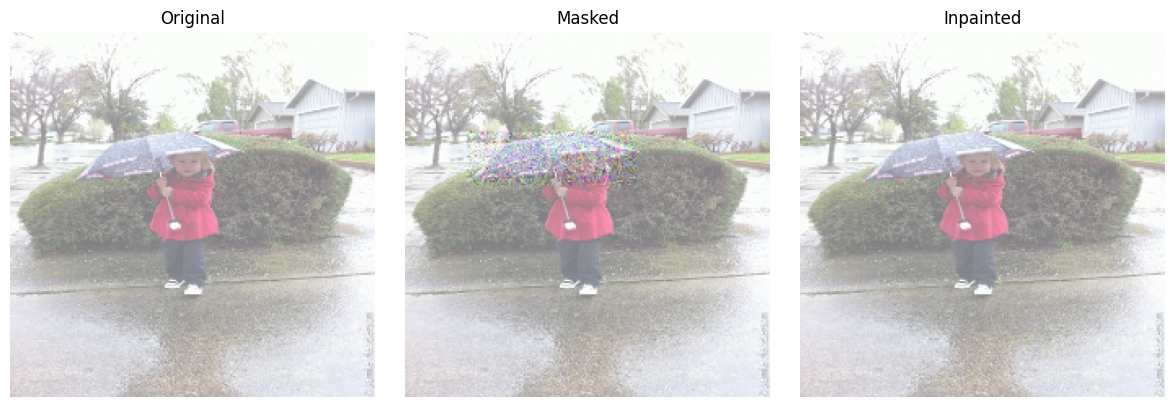

In [103]:
import torch
from diffusers import UNet2DModel, DDPMScheduler
import matplotlib.pyplot as plt
import numpy as np

#model = UNet2DModel.from_pretrained("ddpm-inpaint-laplace").cuda()
model.eval()

scheduler = DDPMScheduler(num_train_timesteps=1000)
scheduler.set_timesteps(50)

@torch.no_grad()
def inpaint_ddpm(model, scheduler, masked_img, mask, prior="laplace"):
    bsz = masked_img.shape[0]

    if prior == "gaussian":
        x = torch.randn_like(masked_img)
    elif prior == "laplace":
        x = torch.distributions.Laplace(0, 1).sample(masked_img.shape).to(masked_img.device)
    elif prior == "uniform":
        x = torch.rand_like(masked_img) * 2 - 1
    else:
        raise Exception("invalid dist")

    for i, t in enumerate(scheduler.timesteps):
        model_input = torch.cat([masked_img, mask], dim=1)
        noise_pred = model(model_input, t).sample
        x = scheduler.step(noise_pred, t, x).prev_sample

        x = mask * masked_img + (1 - mask) * x

    return x

def show_image(tensor, title):
    img = tensor.squeeze().detach().cpu()
    img = (img * 0.5 + 0.5).clamp(0, 1).permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")

model.eval()
test_masked_img = masked_imgs[2].unsqueeze(0).cuda()
test_orig_img = orig_imgs[2].unsqueeze(0).cuda()

mask = (test_masked_img != 0).float().mean(1, keepdim=True)

reconstructed = inpaint_ddpm(model, scheduler, test_orig_img, mask, prior="gaussian")

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1); show_image(test_orig_img/255, "Original")
plt.subplot(1, 3, 2); show_image(test_masked_img, "Masked")
plt.subplot(1, 3, 3); show_image(reconstructed/255, "Inpainted")
plt.tight_layout()
plt.show()